<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [4]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [26]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,...,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,...,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,...,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,...,5.223676e-06,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,...,1.035016e-06,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13


In [17]:
df_final_train.shape

(100002, 54)

In [27]:
df_final_test.shape

(50002, 54)

In [5]:
df_final_train.source_node.values

array([ 273084,  832016, 1325247, ...,  794228,  949992, 1642037])

## PREFERENTIAL ATTACHMENT

In [6]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [25]:
if os.path.isfile('data/after_eda/test_after_eda.csv'):
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(test_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490


In [7]:
class preferential_attachment():

    
    def __init__(self,a,b):
        self.a = a
        self.b = b
    
    def followers(graph,a,b):
        x_followers = len(set(graph.predecessors(a))) * len(set(graph.predecessors(b)))
        return x_followers
    
    def followees(graph,a,b):
        x_followees = len(set(graph.successors(a))) * len(set(graph.successors(b)))
        return x_followees

In [8]:
pref_followers = preferential_attachment.followers(train_graph,848424,784690)
pref_followees = preferential_attachment.followees(train_graph,848424,784690)

In [11]:
train_source = df_final_train.source_node.values
train_dest = df_final_train.destination_node.values

In [28]:
test_source = df_final_test.source_node.values
test_dest = df_final_test.destination_node.values

In [12]:
from itertools import zip_longest

#### for train data

In [21]:
train_pref_followers=[]
train_pref_followees=[]
for i,j in zip(train_source, train_dest):
    try:
        train_pref_followers.append(preferential_attachment.followers(train_graph, i, j))
        train_pref_followees.append(preferential_attachment.followees(train_graph,i,j))
    except:
        train_pref_followers.append(0)
        train_pref_followees.append(0)

#### for test data

In [29]:
test_pref_followers=[]
test_pref_followees=[]
for i,j in zip(test_source, test_dest):
    try:
        test_pref_followers.append(preferential_attachment.followers(train_graph, i, j))
        test_pref_followees.append(preferential_attachment.followees(train_graph,i,j))
    except:
        test_pref_followers.append(0)
        test_pref_followees.append(0)

In [30]:
len(test_pref_followers)

50002

In [31]:
len(test_pref_followers)

50002

### Add it to the dataframe

In [35]:
df_final_train['pref_followers'] = train_pref_followers
df_final_train['pref_followees'] = train_pref_followees

df_final_test['pref_followers'] = test_pref_followers
df_final_test['pref_followees'] = test_pref_followees

In [36]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_followers,pref_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,22,35
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,33


## SVD DOT FEATURES

In [25]:
def svd_dot_features(df):
    
    vs_val =[]
    vd_val=[]
    us_val=[]
    ud_val=[]

    for index, rows in df.iterrows():

        vs_val.append(rows['svd_v_s_1'] * rows['svd_v_s_2'] * rows['svd_v_s_3'] * rows['svd_v_s_4'] * rows['svd_v_s_5'] * rows['svd_v_s_6'])
        vd_val.append(rows['svd_v_d_1'] * rows['svd_v_d_2'] * rows['svd_v_d_3'] * rows['svd_v_d_4'] * rows['svd_v_d_5'] * rows['svd_v_d_6'])
        us_val.append(rows['svd_u_s_1'] * rows['svd_u_s_2'] * rows['svd_u_s_3'] * rows['svd_u_s_4'] * rows['svd_u_s_5'] * rows['svd_u_s_6'])
        ud_val.append(rows['svd_u_d_1'] * rows['svd_u_d_2'] * rows['svd_u_d_3'] * rows['svd_u_d_4'] * rows['svd_u_d_5'] * rows['svd_u_d_6'])
    
    total_u = (us_val * ud_val)
    total_v = (vs_val * vd_val)
    
    return total_u, total_v

In [37]:
def svd_dot(df):
    vs_val=[]
    vd_val=[]
    us_val=[]
    ud_val=[]

    for index, rows in df.iterrows():

        vs_val.append(rows['svd_v_s_1'] * rows['svd_v_s_2'] * rows['svd_v_s_3'] * rows['svd_v_s_4'] * rows['svd_v_s_5'] * rows['svd_v_s_6'])
        vd_val.append(rows['svd_v_d_1'] * rows['svd_v_d_2'] * rows['svd_v_d_3'] * rows['svd_v_d_4'] * rows['svd_v_d_5'] * rows['svd_v_d_6'])
        us_val.append(rows['svd_u_s_1'] * rows['svd_u_s_2'] * rows['svd_u_s_3'] * rows['svd_u_s_4'] * rows['svd_u_s_5'] * rows['svd_u_s_6'])
        ud_val.append(rows['svd_u_d_1'] * rows['svd_u_d_2'] * rows['svd_u_d_3'] * rows['svd_u_d_4'] * rows['svd_u_d_5'] * rows['svd_u_d_6'])

    total_u = pd.DataFrame(data={'us':[i for i in us_val], 'ud':[i for i in ud_val]})    
    total_v = pd.DataFrame(data={'vs':[i for i in vs_val], 'vd':[i for i in vd_val]})       

#     print(total_u.shape)
    return total_u, total_v

#### for train data

In [38]:
u_train, v_train = svd_dot(df_final_train)

In [40]:
u_train.head()

,ud,us
0,-1.144415e-64,-4.703621e-67
1,4.774699e-52,2.754905e-54
2,4.055871e-109,4.467858e-108
3,-5.425976e-69,-1.018092e-73
4,-6.511555e-73,-1.054912e-72


#### for test data

In [42]:
u_test, v_test = svd_dot(df_final_test)

#### adding to the dataframe

In [43]:
values = []
for index, row in u_train.iterrows():
    val = row['us'] * row['ud']
    values.append(val)

df_final_train['svd_dot_u'] = [i for i in values]

In [44]:
values = []
for index, row in v_train.iterrows():
    val = row['vs'] * row['vd']
    values.append(val)

df_final_train['svd_dot_v'] = [i for i in values]

In [45]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_followers,pref_followees,svd_dot_u,svd_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,5.382893e-131,2.328687e-138
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,1.315384e-105,1.649374e-108
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902,1.812105e-216,1.957870e-222
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,22,35,5.524143e-142,4.550783e-132
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,33,6.869120e-145,-0.000000e+00


In [46]:
values = []
for index, row in u_test.iterrows():
    val = row['us'] * row['ud']
    values.append(val)

df_final_test['svd_dot_u'] = [i for i in values]

In [47]:
values = []
for index, row in v_test.iterrows():
    val = row['vs'] * row['vd']
    values.append(val)

df_final_test['svd_dot_v'] = [i for i in values]

In [48]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_followers,pref_followees,svd_dot_u,svd_dot_v
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,...,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,84,54,1.362312e-143,3.755111e-127
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,...,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,34,19,2.063751e-150,1.563752e-137
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,...,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,150,144,2.026665e-134,7.798511e-137
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,...,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,407,340,5.205360e-121,2.305404e-125
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,...,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,324,405,1.154745e-127,2.711350e-131


### Exporting

In [49]:
df_final_train.to_csv('df_final_train_all.csv')
df_final_test.to_csv('df_final_test_all.csv')

### Data Visualization

In [45]:
from sklearn.manifold import TSNE

In [63]:
tsne = TSNE(n_components=2).fit_transform(df_final_train[:10000])

In [64]:
tsne_df = pd.DataFrame(tsne, columns=['dim1', 'dim2'])

In [65]:
tsne_df['label'] = y_train[:10000]

In [51]:
import seaborn as sns

In [67]:
tsne_df.fillna(value=0, axis=0, inplace=True)

In [68]:
tsne_df.head()

,dim1,dim2,label
0,71.228371,11.263662,1.0
1,15.688890,-95.975334,1.0
2,43.544891,-55.170380,0.0
3,-8.640570,36.854778,0.0
4,-11.324035,20.808897,0.0


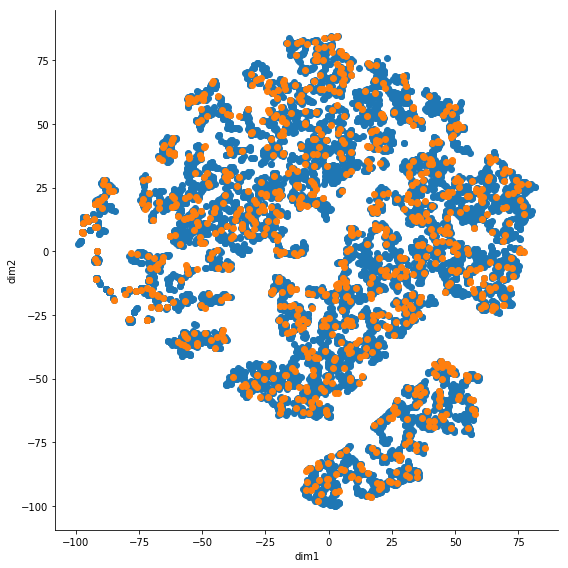

In [70]:
sns.FacetGrid(tsne_df, hue='label', height=8).map(plt.scatter, 'dim1', 'dim2')

### Importing (if needed)

In [7]:
df_final_train = pd.read_csv('df_final_train_all.csv')
df_final_test = pd.read_csv('df_final_test_all.csv')

In [8]:
df_final_train.shape

(100002, 59)

In [9]:
df_final_train.drop(labels=['Unnamed: 0'], inplace=True,axis=1)
df_final_test.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

In [10]:
df_final_train.shape

(100002, 58)

### Model

In [11]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [12]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [13]:
df_final_train.shape

(100002, 55)

In [14]:
df_final_test.shape

(50002, 55)

In [15]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_followers', 'pref_followees', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

### Random forest classifier

Estimators =  10 Train Score 0.9150545972795674 test Score 0.9103378634240753
Estimators =  50 Train Score 0.9176359931023672 test Score 0.9123226727104843
Estimators =  100 Train Score 0.9186409434634156 test Score 0.9143397415694925
Estimators =  250 Train Score 0.9196526766729861 test Score 0.9125661180536531
Estimators =  450 Train Score 0.9205880814105583 test Score 0.9135376325980805


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

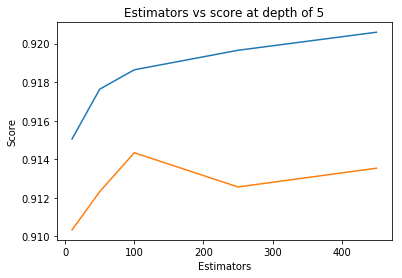

In [56]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []

for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
    
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8853267055838093 test Score 0.8569288068838563
depth =  9 Train Score 0.9556087187666136 test Score 0.9228074618046763
depth =  11 Train Score 0.9606332905434317 test Score 0.9235351273710447
depth =  15 Train Score 0.9629192325309176 test Score 0.9256264645654331
depth =  20 Train Score 0.9633234445482993 test Score 0.926322444678609
depth =  35 Train Score 0.9633746152048686 test Score 0.926296710013278
depth =  50 Train Score 0.9633746152048686 test Score 0.926296710013278
depth =  70 Train Score 0.9633746152048686 test Score 0.926296710013278
depth =  130 Train Score 0.9633746152048686 test Score 0.926296710013278


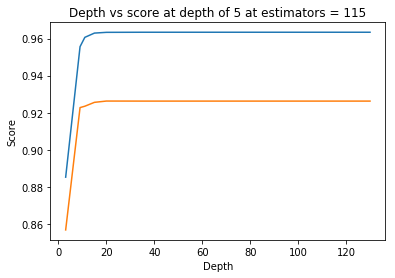

In [57]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [58]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.9618273  0.96235223 0.96054857 0.96106603 0.96299829]
mean train scores [0.96296072 0.96296808 0.96082918 0.96228931 0.96418863]


In [59]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [60]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [61]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [62]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9638921025391219
Test f1 score 0.9257162102427011


In [50]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


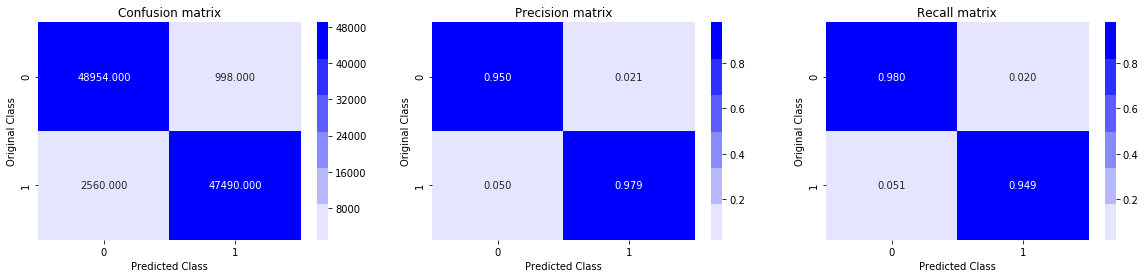

Test confusion_matrix


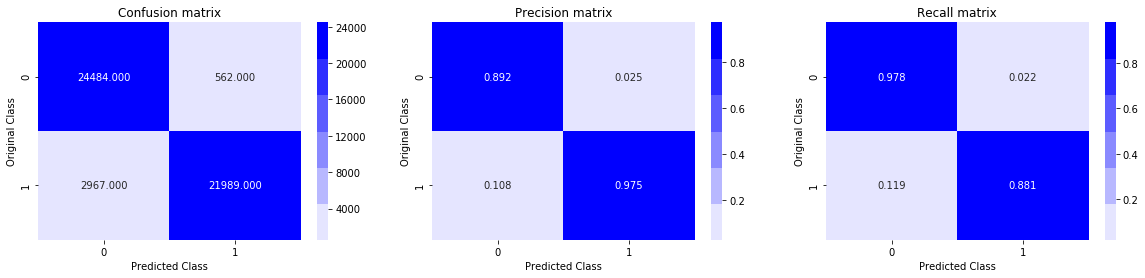

In [64]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

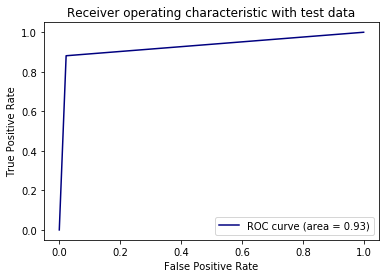

In [65]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

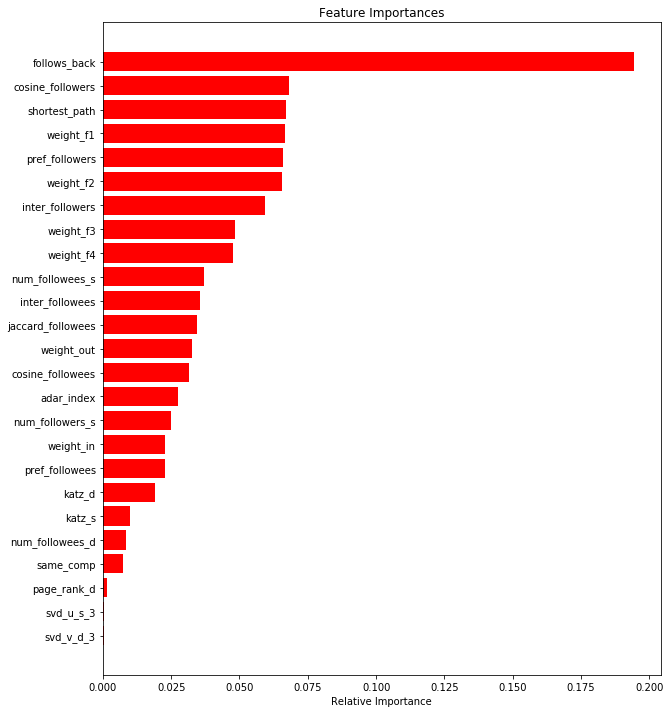

In [66]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [ ]:
# https://stackoverflow.com/questions/44249285/how-to-pass-fit-params-to-fit-a-randomizedsearchcv-getting-index-out-of-range-er
# https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
# https://stackoverflow.com/questions/42993550/gridsearchcv-xgboost-early-stopping

In [16]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from datetime import datetime

In [17]:
x_train,  x_cv, y_train, y_cv = train_test_split(df_final_train.values, y_train, test_size = 0.2, random_state = 43)

In [37]:
%%time

clf = XGBClassifier(n_jobs=4, random_state=42, objective='binary:logistic')

# 'tree_method': ['gpu_hist'] add in params for gpu training
params={'colsample_bylevel':[0.4, 0.6, 0.8],
        'subsample':[0.4,0.6,0.8],
        'learning_rate':[0.1,0.2,0.3],
        'n_estimators':[int(x) for x in np.linspace(start=100, stop=500, num=100)],
        'max_depth':[6,8,12,16],
        'gamma':[0.1,0.2,0.3]}

oldparams = {'eval_metric':'logloss', 'early_stopping_rounds':8, 'eval_set': [(x_cv, y_cv)]}

model = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=5, 
                           n_jobs=4, verbose=1, fit_params=oldparams, cv=3, scoring='neg_log_loss', refit=False)

model.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/karthikmgcp/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 212 ms, sys: 124 ms, total: 336 ms
Wall time: 6min 13s


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  6.2min finished


### Applying learned values

In [38]:
model.best_params_

{'colsample_bylevel': 0.6,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 217,
 'subsample': 0.6}

In [18]:
from sklearn.metrics.classification import accuracy_score, log_loss, precision_score, recall_score, f1_score, fbeta_score

In [59]:
%%time

clf = XGBClassifier(colsample_bylevel=0.6, gamma=0.2, learning_rate=0.1 
                    ,max_depth=8, n_estimators=217, subsample=0.6, n_jobs=4, random_state=42)

from sklearn.calibration import CalibratedClassifierCV
log_error_array=[]
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)
predict_y = sig_clf.predict_proba(df_final_test.values)
log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
print("The log loss is:",log_loss(y_test, predict_y, eps=1e-15))
# print('end time', datetime.now() - start)

The log loss is: 0.27311926130339725
CPU times: user 4min 9s, sys: 332 ms, total: 4min 10s
Wall time: 1min 2s


Total number of data points : 50002


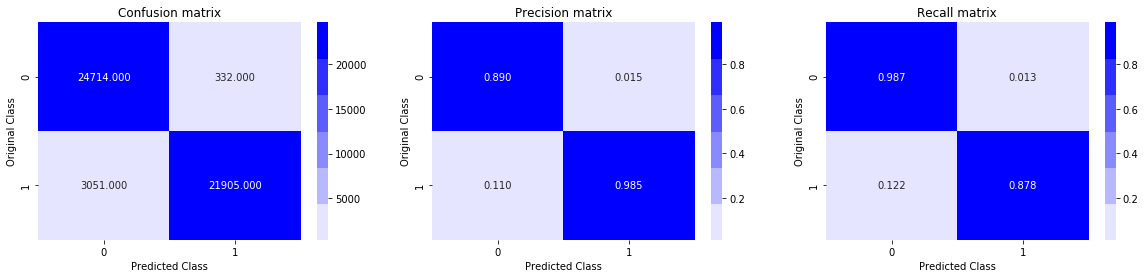

In [73]:
real_predict_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predict_y))
plot_confusion_matrix(y_test, real_predict_y)

In [77]:
real_predict_y

array([1, 1, 1, ..., 0, 0, 0])

In [78]:
print("The precision is:",precision_score(y_test.values, real_predict_y, average='micro'))
print("The recall is:",recall_score(y_test.values, real_predict_y, average='micro'))
print("The fbeta is:",fbeta_score(y_test.values, real_predict_y, 0.1))

The precision is: 0.9323427062917483
The recall is: 0.9323427062917483
The fbeta is: 0.9838788147231057


In [87]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, real_predict_y)

Text(0.5, 1.0, 'roc curve')

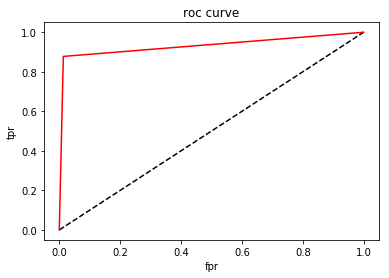

In [85]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, 'r-')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve')

In [86]:
# https://www.kaggle.com/questions-and-answers/39659

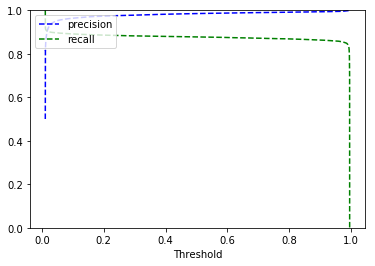

In [89]:
prec, rec, tre = precision_recall_curve(y_test, predict_y[:,1], )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

### feature importances

In [ ]:
# https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

In [19]:
clf = XGBClassifier(colsample_bylevel=0.6, gamma=0.2, learning_rate=0.1 
                    ,max_depth=8, n_estimators=217, subsample=0.6, n_jobs=4, random_state=42)
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=217,
       n_jobs=4, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [21]:
sorted_idx = np.argsort(clf.feature_importances_.ravel())[::-1]

In [22]:
feature_imps = []
for index in sorted_idx:
    print([df_final_train.columns[index], clf.feature_importances_[index]]) 
    feature_imps.append([df_final_train.columns[index], clf.feature_importances_[index]])

['page_rank_d', 0.04141264]
['shortest_path', 0.036431227]
['svd_v_d_3', 0.035464685]
['authorities_d', 0.03449814]
['svd_v_d_4', 0.033605948]
['svd_u_s_3', 0.03330855]
['svd_v_d_5', 0.032936804]
['svd_u_s_1', 0.032490708]
['hubs_s', 0.03174721]
['svd_u_s_4', 0.031003717]
['svd_v_d_1', 0.03070632]
['svd_u_s_2', 0.029888475]
['svd_u_s_5', 0.029814126]
['katz_d', 0.02944238]
['svd_v_d_2', 0.02929368]
['katz_s', 0.026468402]
['num_followees_s', 0.022081785]
['svd_u_d_3', 0.021710036]
['svd_u_d_2', 0.021486988]
['svd_v_s_2', 0.020669146]
['svd_v_s_3', 0.020371748]
['svd_u_d_1', 0.020371748]
['page_rank_s', 0.020074349]
['svd_v_s_5', 0.019628253]
['svd_v_s_1', 0.019479554]
['svd_u_d_5', 0.019182157]
['svd_u_d_4', 0.019182157]
['svd_v_s_4', 0.018810408]
['svd_u_s_6', 0.018215613]
['authorities_s', 0.017769517]
['weight_f3', 0.016133828]
['weight_f4', 0.015687732]
['svd_v_d_6', 0.015390335]
['hubs_d', 0.014349442]
['num_followees_d', 0.014349442]
['weight_f1', 0.013977695]
['pref_followers', 

In [ ]:
# https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names

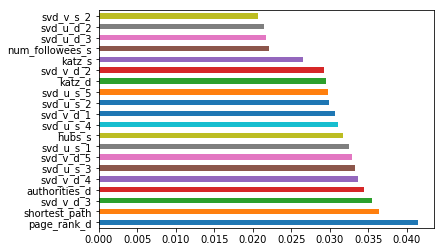

In [43]:
pd.Series(clf.feature_importances_, index=df_final_train.columns).nlargest(20).plot(kind='barh')

### Results

In [1]:
from prettytable import PrettyTable

In [25]:
x = PrettyTable(field_names=(['s.no', 'algorithm', 'logloss', 'precision', 'recall', 'fBeta', 'most important feature']))

In [26]:
x.add_row([1,'xgboost', 0.27, 0.93, 0.93, 0.98, 'page rank feature'])

In [27]:
print(x)

+------+-----------+---------+-----------+--------+-------+------------------------+
| s.no | algorithm | logloss | precision | recall | fBeta | most important feature |
+------+-----------+---------+-----------+--------+-------+------------------------+
|  1   |  xgboost  |   0.27  |    0.93   |  0.93  |  0.98 |   page rank feature    |
+------+-----------+---------+-----------+--------+-------+------------------------+


### Summary

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.